# Transformers for Language Modeling

Welcome to the Transformers module! In this notebook, we’ll explore the core concepts of transformer architectures, learn how they work, and implement and fine-tune them using both Hugging Face and PyTorch.


### Learning Objectives

- Understand the motivation behind transformers.
- Implement self-attention and positional encoding.
- Explore the transformer architecture in detail.
- Use Hugging Face to fine-tune transformer models.
- Implement a mini transformer (NanoTransformer) from scratch.


# Self-Attention: Recap & Deeper Dive

## Why Attention?

In the last session, we saw how **attention mechanisms** help models **focus on relevant parts** of the input sequence. Unlike RNNs, which compress everything into a hidden state, attention allows dynamic interaction between tokens.

Example problem RNNs struggle with:

>"*The dog, which was barking loudly, ran after the mailman.*"
>
>An RNN may forget "the dog" by the time it needs to decide "ran".

**Attention solves this** by letting each word look at the **entire sequence** when generating an output.

### Self-Attention Intuition

Self-attention computes **relationships between all tokens** in a sequence. Each word decides *how much attention* to pay to other words.

Every token becomes:

* a **Query**: What am I looking for?
* a **Key**: What do I offer?
* a **Value**: What do I contribute if selected?

## Step-by-Step Example:

Let’s say we have 3 tokens in a sentence: `"The"`, `"cat"`, `"sat"`.

Assume their embeddings are:

In [1]:
import torch

# Each word represented by a 4D embedding
x = torch.tensor([
    [1.0, 0.0, 1.0, 0.0],  # "The"
    [0.0, 1.0, 0.0, 1.0],  # "cat"
    [1.0, 1.0, 1.0, 1.0],  # "sat"
])  # shape: (3, 4)


Define **Q**, **K**, **V** matrices (random small weights):

In [2]:
import torch.nn.functional as F

# Weight matrices (4 -> 2)
W_Q = torch.randn(4, 2)
W_K = torch.randn(4, 2)
W_V = torch.randn(4, 2)

Q = x @ W_Q  # shape: (3, 2)
K = x @ W_K
V = x @ W_V

Compute Attention Scores:

In [3]:
# Scaled dot-product attention
scores = Q @ K.T  # shape: (3, 3)
scaled_scores = scores / torch.sqrt(torch.tensor(Q.shape[-1], dtype=torch.float32))
weights = F.softmax(scaled_scores, dim=-1)

Get Final Output:

In [6]:
# Weighted sum of values
attn_output = weights @ V  # shape: (3, 2)
attn_output

tensor([[0.0044, 0.6334],
        [0.1284, 1.4725],
        [0.0459, 0.9282]])

#### Visualization: Token-to-Token Attention Heatmap

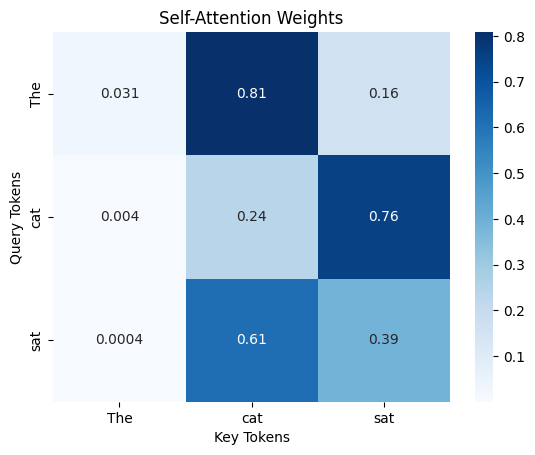

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(weights.detach().numpy(), annot=True, cmap="Blues", xticklabels=["The", "cat", "sat"], yticklabels=["The", "cat", "sat"])
plt.title("Self-Attention Weights")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.show()


This heatmap shows how each token attends to the others. Diagonal dominance means the token mostly attends to itself.

## Resource: BertViz

Explore attention weights visualization with this interactive tutorial notebook: [BertViz Interactive Tutorial](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing#scrollTo=T3H0qUZvPOP4)

# Positional Encoding

Transformers do **not process input tokens sequentially** (like RNNs do), so they **don’t know the order** of the input unless we explicitly tell them.

To fix this, we add **positional encodings** to token embeddings to inject information about a token’s position in the sequence.

## Basic Integer-Based Positions

We start with a very simple idea — just give each token a number representing its position:

In [7]:
import torch

seq_len = 10  # e.g., sentence with 10 tokens
positions = torch.arange(seq_len)
print("Positions:", positions)

Positions: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


We can then turn this into an embedding:

In [8]:
import torch.nn as nn

position_embedding = nn.Embedding(num_embeddings=seq_len, embedding_dim=16)
pos_embed = position_embedding(positions)
print("Position Embeddings Shape:", pos_embed.shape)

Position Embeddings Shape: torch.Size([10, 16])


While effective, **original Transformers used sinusoidal encodings**, which we’ll implement next.

## Sinusoidal Positional Encodings

Let’s implement the **sinusoidal encoding** as described in [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762).

$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d}}}\right), \quad PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

In [15]:
import math
import torch

def get_sinusoidal_positional_encoding(seq_len, d_model):
    pe = torch.zeros(seq_len, d_model)
    position = torch.arange(0, seq_len, dtype=torch.float32).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    
    return pe

# Example
pos_encoding = get_sinusoidal_positional_encoding(seq_len=100, d_model=64)
print("Sinusoidal Positional Encoding Shape:", pos_encoding.shape)


Sinusoidal Positional Encoding Shape: torch.Size([100, 64])


#### Visualize Positional Encodings

Let’s plot some dimensions across different positions to see the wave patterns.

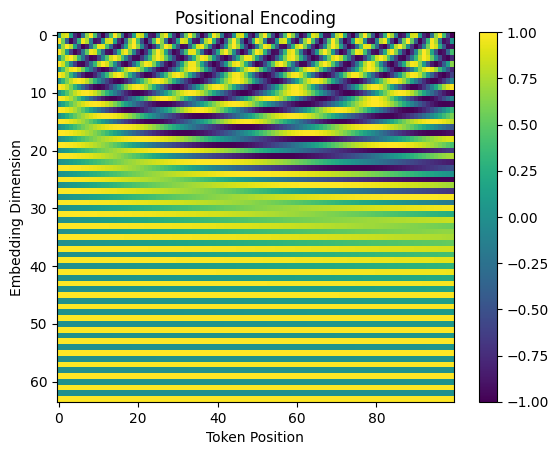

In [17]:
import matplotlib.pyplot as plt

plt.imshow(pos_encoding.T, cmap="viridis", aspect="auto")
plt.title("Positional Encoding")
plt.xlabel("Token Position")
plt.ylabel("Embedding Dimension")
plt.colorbar()
plt.show()
